## 任务要求
- 使用正则表达式统计代码连接、页数和图表数据；

## 导入库、配置环境和读入数据

In [4]:
import re #用于正则表达式，匹配字符串的模式
import json #读取数据，我们的数据为json格式的
import pandas as pd #数据处理，数据分析
import matplotlib.pyplot as plt #画图工具
#>================cHEn================<
plt.rcParams['axes.unicode_minus'] = False	
plt.rcParams['font.sans-serif'] = 'SimHei'
# 因为我的环境下背景为黑色，黑色字体看不清，这里换了下颜色
plt.rcParams["xtick.color"] = 'orange'
plt.rcParams["ytick.color"] = 'orange'
plt.rcParams["text.color"] = 'orange'
# 实现渐变
from matplotlib import cm
import numpy as np
map_vir = cm.get_cmap(name='CMRmap')
color = map_vir(np.linspace(0,1,100))

In [5]:
def readArxivFile(path, columns=['id', 'submitter', 'authors', 'title', 'comments', 'journal-ref', 'doi',
                                 'report-no', 'categories', 'license', 'abstract', 'versions',
                                 'update_date', 'authors_parsed'], count=None):
    data = []
    with open(path,'r') as f:
        for idx,line in enumerate(f):
            if idx == count:
                break
            
            d = json.loads(line)
            d = {col:d[col] for col in columns}
            data.append(d)
    
    data = pd.DataFrame(data)
    return data

In [6]:
data = readArxivFile('../arxiv-metadata-oai-snapshot.json', ['id', 'abstract', 'categories', 'comments'])

## 代码实现

### 得到主要类别

In [9]:
data['main_categories'] = data['categories'].apply(lambda x: x.split(' ')[0])# 更新得到首个类别
data['main_categories'] = data['main_categories'].apply(lambda x: x.split('.')[0])# 更新得到首个类别的主要类别

### 统计论文页数
在`comments`字段中抽取pages和figures和个数，首先完成字段读取。

In [5]:
# 利用正则表达式获取页数信息
data['pages'] = data['comments'].apply(lambda x:re.findall('[1-9][0-9]* pages',str(x)))

# 筛选有页数信息的论文
data_page = data[data['pages'].apply(len) > 0].copy()

# 得到int型的页数信息
data_page['pages'] = data_page['pages'].apply(lambda x: int(x[0].replace(' pages', '')))

In [6]:
# 得到描述性统计信息
data_page['pages'].describe().astype(int)

count    1089180
mean          17
std           22
min            1
25%            8
50%           13
75%           22
max        11232
Name: pages, dtype: int32

### 分类统计论文页数

<AxesSubplot:title={'center':'各方向论文平均page数'}, xlabel='main_categories'>

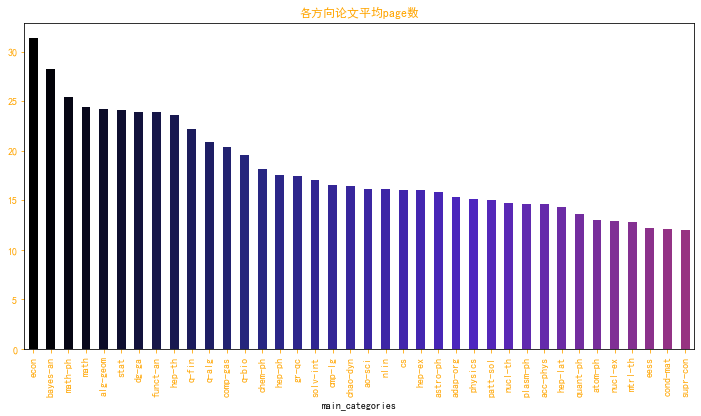

In [105]:
# 绘制画布
plt.figure(figsize=(12, 6))

# 绘制每类论文的平均页数的柱状图
data_page.groupby('main_categories').mean()['pages'].sort_values(ascending=False).plot(kind='bar', title='各方向论文平均page数', color=color, figsize=(12, 6))

### 统计论文图个数
和统计页数思路相同，就不加注释了

In [8]:
# 发现有0 figures的数据
data[data['comments'].apply(lambda x:' 0 figures' in str(x))].count()['id']

2716

In [11]:
# 修改正则表达式
data['figures'] = data['comments'].apply(lambda x:re.findall('[0-9][0-9]* figures',str(x)))
data_fig = data[data['figures'].apply(len) > 0].copy()
data_fig['figures'] = data_fig['figures'].apply(lambda x:x[0].replace(' figures','')).astype(int)

In [10]:
data_fig['figures'].describe().astype(int)

count    647811
mean          7
std          10
min           0
25%           4
50%           6
75%           9
max        4989
Name: figures, dtype: int32

<AxesSubplot:title={'center':'各方向论文总figure数'}, xlabel='main_categories'>

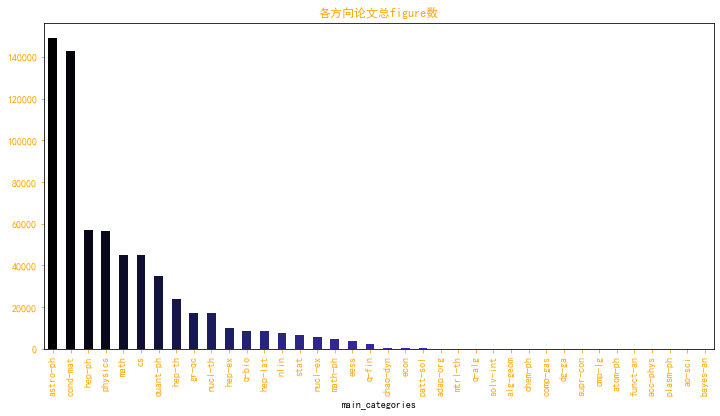

In [111]:
data_fig.groupby('main_categories').count()['figures'].sort_values(ascending=False).plot(kind='bar', title='各方向论文总figure数', color=color, figsize=(12, 6))

<AxesSubplot:title={'center':'各方向论文平均figure数'}, xlabel='main_categories'>

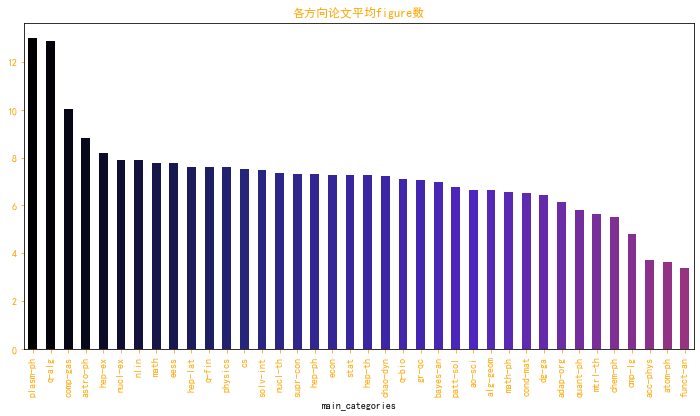

In [106]:
data_fig.groupby('main_categories').mean()['figures'].sort_values(ascending=False).plot(kind='bar', title='各方向论文平均figure数', color=color, figsize=(12, 6))

### 统计论文表个数

In [12]:
data['tables'] = data['comments'].apply(lambda x:re.findall('[0-9][0-9]* tables',str(x)))
data_tab = data[data['tables'].apply(len) > 0].copy()
data_tab['tables'] = data_tab['tables'].apply(lambda x:x[0].replace(' tables','')).astype(int)

In [13]:
data_tab['tables'].describe().astype(int)

count    57959
mean         4
std          8
min          0
25%          2
50%          3
75%          5
max       1500
Name: tables, dtype: int32

<AxesSubplot:title={'center':'各方向论文总table数'}, xlabel='main_categories'>

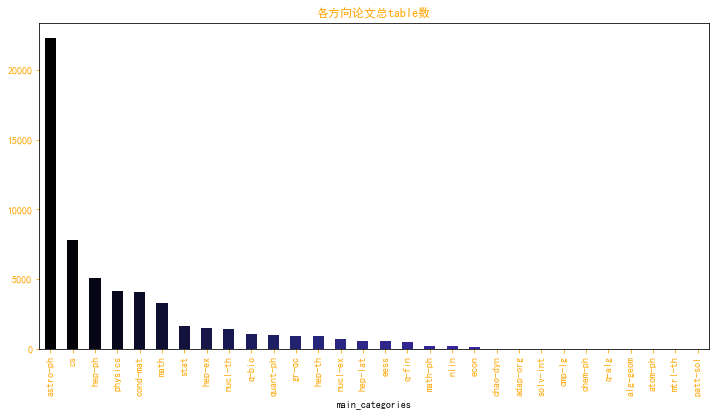

In [113]:
data_tab.groupby('main_categories').count()['tables'].sort_values(ascending=False).plot(kind='bar', title='各方向论文总table数', color=color, figsize=(12, 6))

<AxesSubplot:title={'center':'各方向论文平均table数'}, xlabel='main_categories'>

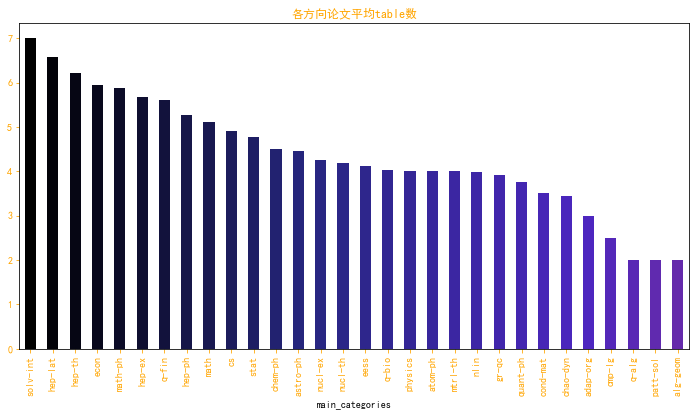

In [107]:
data_tab.groupby('main_categories').mean()['tables'].sort_values(ascending=False).plot(kind='bar', title='各方向论文平均table数', color=color, figsize=(12, 6))

### 统计使用的TeX
发现有些comments里有TeX，这里做统计

In [15]:
data['TeX'] = data['comments'].apply(lambda x:re.findall('[A-z]*TeX',str(x).split('.')[0]))
data_TeX = data[data['TeX'].apply(len) > 0].copy()
data_TeX['TeX'] = data_TeX['TeX'].apply(lambda x:x[0])

In [16]:
data_TeX['TeX'].describe()

count     57912
unique       93
top       LaTeX
freq      38043
Name: TeX, dtype: object

<AxesSubplot:title={'center':'各TeX使用次数图'}, xlabel='TeX'>

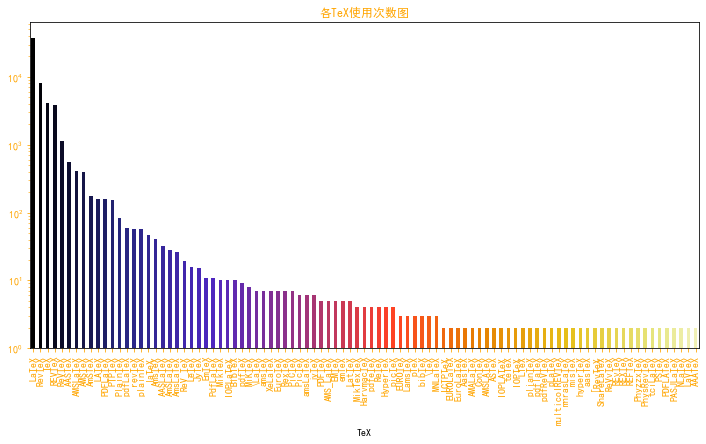

In [108]:
# 统计各TeX的使用次数
data_TeX.groupby('TeX').count()['id'].sort_values(ascending=False).plot(kind='bar', title='各TeX使用次数图', color=color, figsize=(12,6), log=True)# 取对数使得图形上差异不大

### 统计代码链接

In [17]:
# 筛选出包含网址的数据，并且只留下需要的信息
pattern = 'http[s]*://[^\s]*'
data_with_code = data[(data.comments.apply(lambda x:re.findall(pattern,str(x))).apply(len)>0)|
                      (data.abstract.apply(lambda x:re.findall(pattern,str(x))).apply(len)>0)].copy()
# data_with_code = data_with_code.reset_index(drop=True).loc[:,['id','abstract','categories','comments']]

In [18]:
# 合并abstract和comments的文本
data_with_code['text'] = data_with_code['abstract'].fillna('') + data_with_code['comments'].fillna('')
data_with_code['code_flag'] = data_with_code['text'].str.findall(pattern).apply(len)

<AxesSubplot:title={'center':'含代码的论文数量图'}, xlabel='main_categories'>

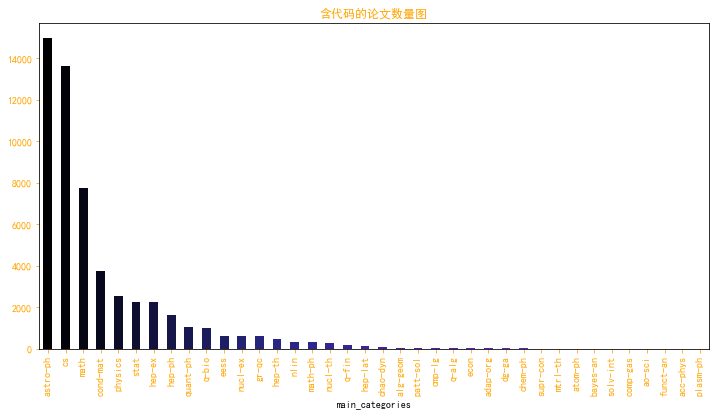

In [109]:
# 对论文按照类别进行绘图
data_with_code = data_with_code[data_with_code['code_flag'] >= 1]
data_with_code.groupby(['main_categories'])['code_flag'].count().sort_values(ascending=False).plot(kind='bar', color=color, figsize=(12, 6), title='含代码的论文数量图')

<AxesSubplot:title={'center':'含代码的论文占比图'}, xlabel='main_categories'>

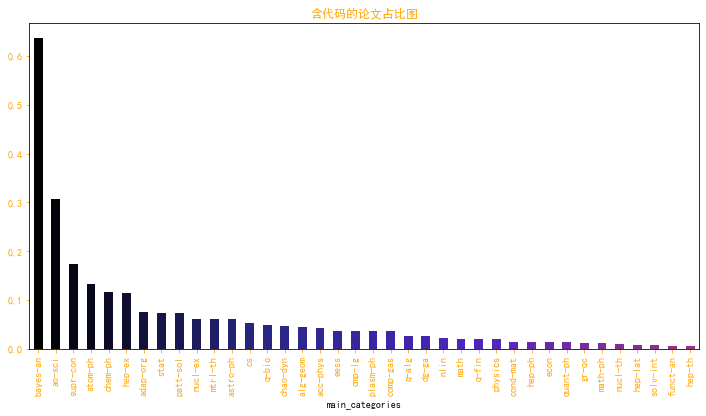

In [110]:
(data_with_code.groupby(['main_categories'])['code_flag'].count()/data.groupby(['main_categories'])['id'].count()).sort_values(ascending=False).plot(kind='bar', color=color, figsize=(12, 6), title='含代码的论文占比图')

相关笔记可以前往：

https://github.com/chenjiyan2001/Datawhale-2021.1-team-learning-AcademicTrends/tree/main/%E7%AC%94%E8%AE%B0